# Data PreProcessing

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing packagesimport pandas as pd
import pandas as pd
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
##Loading csv files
path = r'/content/drive/MyDrive/ColabNotebooks/Lisboa_Estancia/IMU_Trials/all_IMUsamples_final.csv'

df= pd.read_csv(path, skiprows=1, usecols=[0,1,2,3,4,5,6], names=['x1', 'y1', 'z1','x2', 'y2', 'z2','label'])
print (df.info)
print(df.shape)

#label outputs (y) Activities
y = pd.read_csv(path, usecols= [6])
print("y = \n",y)
print(y.shape)

#Standarizing
x = []
scaler = StandardScaler()
x = scaler.fit_transform(df)
x = pd.DataFrame(data = df, columns = ['x1','y1','z1','x2','y2','z2'])
print("x = \n",x)
print(x.shape)

#Verifying data shape
x.shape, y.shape

#Counting number of samples per activity
y['label'].value_counts()

FileNotFoundError: ignored

## Create train and test subdatasets

In [ ]:
### Convert labels from [1,2,3] to [0,1,2]  Do it just in case the values starts in 1.
y = y - 1
print(y)

        label
0           0
1           0
2           0
3           0
4           0
...       ...
380264      2
380265      2
380266      2
380267      2
380268      2

[380269 rows x 1 columns]


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(304215, 6) (76054, 6)
(304215, 1) (76054, 1)


## Graphics

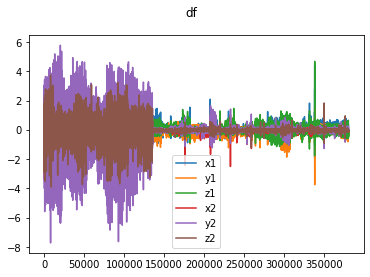

Loaded 380269 subjects


In [ ]:
name = 'df'
columns_names = ['x1','y1','z1','x2','y2','z2']
#plt.plot(df[name])
plt.plot(x)
plt.suptitle(name)
plt.legend(columns_names)
plt.show()

# plot the x, y, z acceleration and activities for multiple subjects
def plot_subject(subject):
	plt.figure()
	# create a plot for each column
	for col in range(subject.shape[0]):
		plt.subplot(subject.shape[0], 1, col+1)
		plt.plot(subject[:,col])
	plt.show()

# load
subjects = df
print('Loaded %d subjects' % len(subjects))


#Sliding Window Proccessing

In [ ]:
print(df.head())
print(df.shape)
#df.loc[3,"y2"]
#df.loc[2:4]
#print(df.loc[2:4])

dataset_size = df.shape[0] ### how many rows
window_size = 100 ### how many time steps we want to process simultaneously

xx = np.array([ x.loc[i:(i+window_size-1)].values for i in range(dataset_size-window_size) ])
#print(xx[0:5]).loc
print("shape(xx) = ", xx.shape)

yy = np.array([ y.loc[i].values for i in range(dataset_size-window_size) ])
print("shape(yy) = ", yy.shape)

#yy = np.array([ y.loc[i:(i+window_size-1)].values for i in range(dataset_size-window_size) ])
#print(yy[0:5])
#print("shape(yy) = ", yy.shape)
#yy[2].shape
#yy.reshape(-1,2)

      x1     y1     z1     x2     y2     z2  label
0  0.542 -1.177 -0.796 -2.141  2.420 -1.393      1
1  0.536 -1.231 -0.780 -2.466 -0.073 -1.819      1
2  0.516 -1.246 -0.779 -0.516 -2.029 -0.664      1
3  0.499 -1.239 -0.787  0.035 -0.993 -1.221      1
4  0.475 -1.207 -0.797 -1.330 -0.199 -2.408      1
(380269, 7)
shape(xx) =  (380169, 100, 6)
shape(yy) =  (380169, 1)


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size = 0.2)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(304135, 100, 6) (76034, 100, 6)
(304135, 1) (76034, 1)


In [ ]:
print(X_train.shape[1])
print(X_train.shape[2])
print(y_train.shape[1])
print(np.unique(y_train).shape[0])
print(X_train.shape[0])


100
6
1
3
304135


# **CNN-LSTM Archicture**

#### Load Tensorflow libraries

In [ ]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
print(tf.version.VERSION)
print(tf.keras.__version__)

2.4.1
2.4.0


304135
76034
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, None, 23, 64)      1216      
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 21, 64)      12352     
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 21, 64)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 10, 64)      0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 640)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               296400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100) 

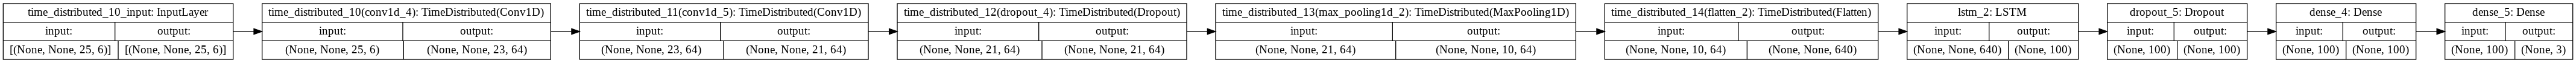

In [ ]:
# Define model
verbose, epochs, batch_size = 1, 25, 64

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], np.unique(y_train).shape[0]
#n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
#n_timesteps, n_features, n_outputs = 100, 6, 3

# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 25
X_train= X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
print(X_train.shape[0])
print(X_test.shape[0])

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Plotting model
plot = tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')
print(model.summary())
plot

In [ ]:
epochs, batch_size = 25, 64
# fit network
start_time = time.perf_counter()

result = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, validation_data=(X_test, y_test))

# evaluate model
end_time = time.perf_counter()
run_time = (end_time - start_time)
print( "time = " + str(int(run_time)) + " s = " + str(int(run_time//60)) + " mins" )

Epoch 1/25
4753/4753 [==============================] - 200s 42ms/step - loss: 0.2056 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.0709 - val_sparse_categorical_accuracy: 0.9755
Epoch 2/25
4753/4753 [==============================] - 201s 42ms/step - loss: 0.0629 - sparse_categorical_accuracy: 0.9766 - val_loss: 0.0402 - val_sparse_categorical_accuracy: 0.9879
Epoch 3/25
4753/4753 [==============================] - 201s 42ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.0232 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/25
4753/4753 [==============================] - 201s 42ms/step - loss: 0.0231 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.0160 - val_sparse_categorical_accuracy: 0.9938
Epoch 5/25
4753/4753 [==============================] - 200s 42ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.0153 - val_sparse_categorical_accuracy: 0.9944
Epoch 6/25
4753/4753 [==============================] - 201s 42ms/step - lo

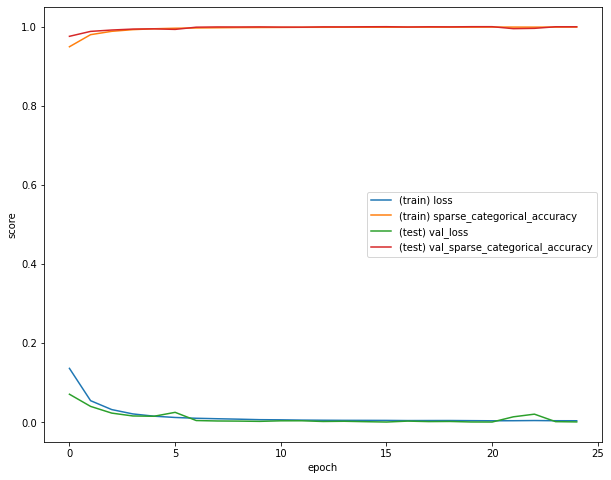

In [ ]:
datafolder = '/content/drive/MyDrive/ColabNotebooks/Lisboa_Estancia/IMU_Trials/'
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
for key in result.history :
  #if key == "loss" or key == "val_loss": continue
  label = ("(test) " if key.startswith("val_") else "(train) ") + key
  plt.plot(result.history[key], label=label)
#ax.set(ylim=[-0.1, 1.1])no h
ax.set(xlabel="epoch", ylabel="score")
ax.legend()
plt.show()
fig.savefig(datafolder + "plot-train_test_loss_metrics_1_CNN_LSTM.png")

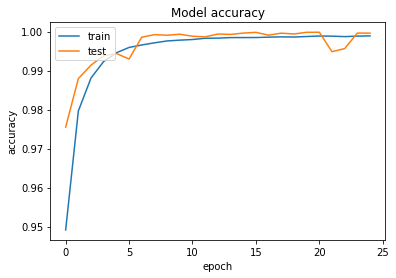

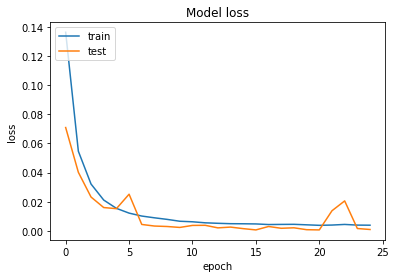

In [ ]:
# summarize history for accuracy
plt.plot(result.history['sparse_categorical_accuracy'])
plt.plot(result.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save and load network

In [ ]:
### Save
dnn_filename = datafolder + "trained_network_p1_CNN_LSTM.h5"
model.save(dnn_filename)
print("Model saved to: " + dnn_filename)

### Load
model = tf.keras.models.load_model(datafolder + "trained_network_p1_CNN_LSTM.h5")
model.summary()

Model saved to: /content/drive/MyDrive/ColabNotebooks/Lisboa_Estancia/IMU_Trials/trained_network_p1_CNN_LSTM.h5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, None, 23, 64)      1216      
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 21, 64)      12352     
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 21, 64)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 10, 64)      0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 640)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               296400    
________

## Predict new data

**Data de las 2 últimas personas para hacer la predicción**

In [ ]:
y_pred = model.predict(X_test)
#y_pred = model.predict_classes(X_test) #Predict classes error using this after january 2021. Suggesting us np way.
print(y_pred.shape)
print(y_pred[0:20])

loss_function = 'sparse_categorical_crossentropy'
score_function = 'sparse_categorical_accuracy'

scores = model.evaluate(X_test, y_test)
print(loss_function," = ",scores[0])
print(score_function," = ",scores[1])

(76034, 3)
[[1.00000000e+00 3.46856223e-15 9.11359204e-14]
 [2.88004585e-11 3.11368015e-11 1.00000000e+00]
 [2.40604106e-08 9.99999762e-01 2.52848167e-07]
 [1.00000000e+00 1.23614896e-17 8.41226801e-17]
 [2.41272353e-08 1.00000000e+00 3.10394839e-08]
 [2.19180038e-07 9.99999762e-01 3.12280761e-08]
 [1.00000000e+00 4.42856168e-16 1.02351087e-16]
 [1.78403006e-05 9.99981880e-01 2.77308573e-07]
 [2.70785762e-07 9.99998808e-01 9.92008495e-07]
 [1.77038501e-07 9.99999285e-01 5.66242363e-07]
 [1.00000000e+00 4.75735801e-15 9.11680752e-18]
 [1.00000000e+00 5.39315274e-17 2.04926006e-17]
 [7.35525063e-08 9.99999881e-01 1.44591406e-08]
 [1.00000000e+00 8.37645665e-12 1.45936926e-11]
 [1.02662746e-07 9.99999404e-01 4.51579581e-07]
 [1.00000000e+00 2.50196195e-17 4.71262828e-18]
 [1.00000000e+00 3.34139422e-12 6.30613725e-13]
 [3.69358655e-09 1.00000000e+00 6.08063822e-10]
 [1.00000000e+00 3.88185803e-11 2.36247438e-10]
 [1.92675571e-07 4.95233337e-07 9.99999285e-01]]
2377/2377 [=================

Testing Accuracy: sparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_categorical_accuracysparse_cat

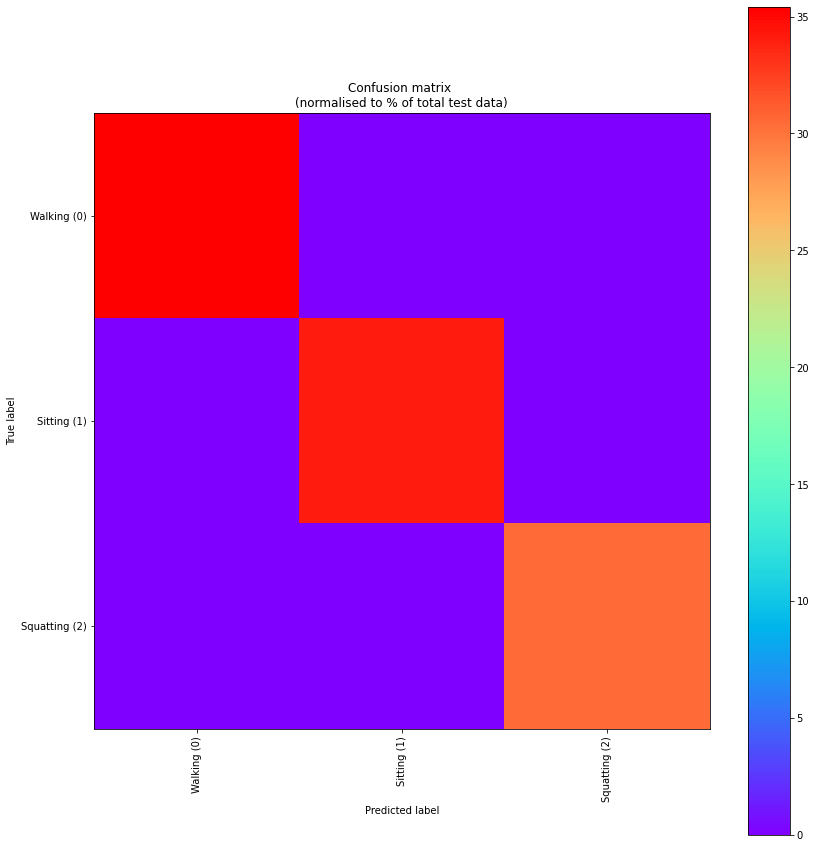

In [ ]:
# Results
import mlxtend

from sklearn import metrics
predictions = y_pred.argmax(1)

print("Testing Accuracy: {}%".format(100*score_function))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(normalised_confusion_matrix,interpolation='nearest', cmap=plt.cm.rainbow)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
LABELS = ['Walking (0)', 'Sitting (1)', 'Squatting (2)']
tick_marks = np.arange(n_outputs)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

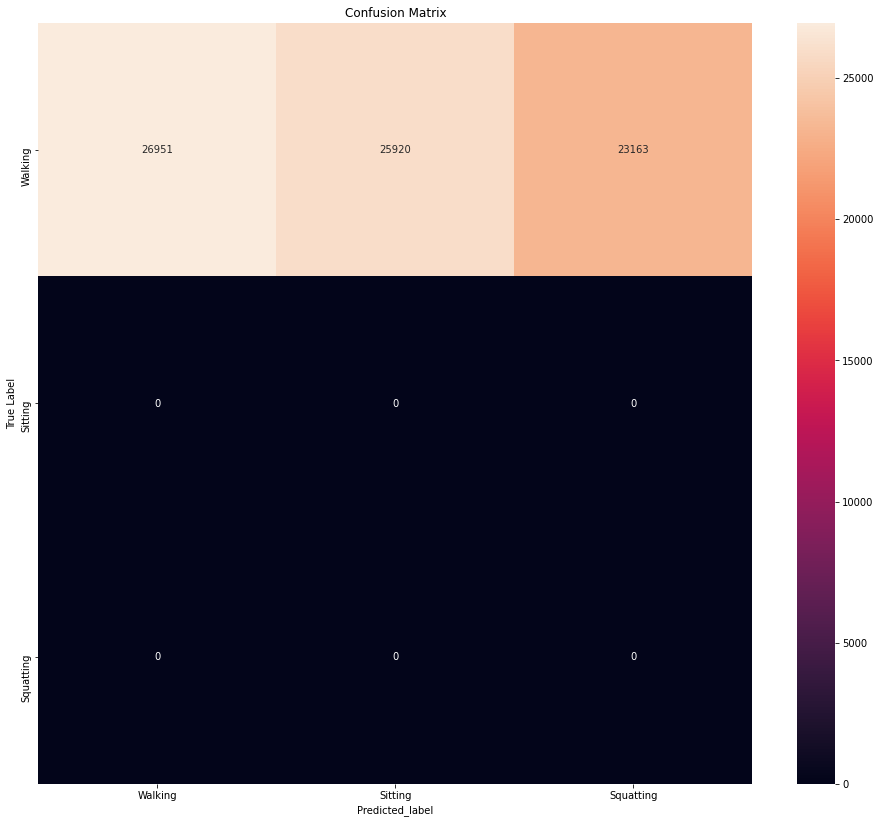

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(y_pred, axis = 1)
confusion_matrix = confusion_matrix(max_test, max_predictions)
LABELS = ['Walking', 'Sitting', 'Squatting']

plt.figure(figsize=(16,14))
sns.heatmap(confusion_matrix, xticklabels = LABELS, yticklabels = LABELS, annot =True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel('Predicted_label')
plt.ylabel('True Label')
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f612cd64910>)

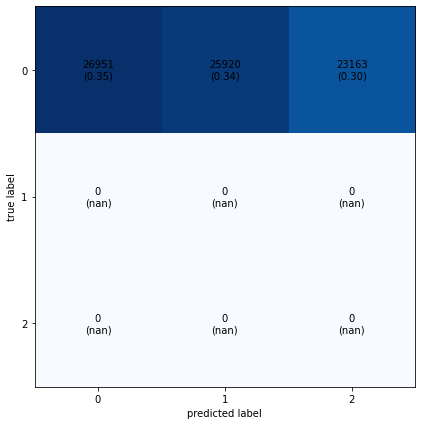

In [ ]:
# Confusion matrix
#!pip3 install mlxtend
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np

max_test = np.argmax(y_test, axis= 1)
max_predictions = np.argmax(y_pred, axis = 1)
mat = confusion_matrix(max_test, max_predictions)

# plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

In [ ]:
# fit and evaluate a model
def built_model(trainX, trainy, testX, testy):
  # define model
  verbose, epochs, batch_size = 1, 1, 64

  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], np.unique(trainy).shape[0]
  #n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  #n_timesteps, n_features, n_outputs = 100, 6, 3

  # reshape data into time steps of sub-sequences
  n_steps, n_length = 4, 25
  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
  model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

  # Plotting model
  plot = tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')
  print(model.summary())
  plot

  # fit network
  result = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

  # evaluate model
  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)
  return accuracy, result

built_model(X_train, y_train, X_test, y_test)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_25 (TimeDis (None, None, 23, 64)      1216      
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 21, 64)      12352     
_________________________________________________________________
time_distributed_27 (TimeDis (None, None, 21, 64)      0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, None, 10, 64)      0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, None, 640)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               296400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)              

(0.9734460711479187,
 <tensorflow.python.keras.callbacks.History at 0x7fc1656cf250>)